In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [2]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all=hf.add_MSI_noise(data_all,channel_labels)

Noise standard deviation for Cloud_B02: 0.00335001428051948
Noise standard deviation for Cloud_B03: 0.002912530185416667
Noise standard deviation for Cloud_B04: 0.004058081082042254
Noise standard deviation for Cloud_B05: 0.0046524891611111115
Noise standard deviation for Cloud_B06: 0.007455351321348316
Noise standard deviation for Cloud_B07: 0.008871707484285717
Noise standard deviation for Cloud_B08: 0.04489677938000001
Noise standard deviation for Cloud_B09: 0.005688141120114942
Noise standard deviation for Cloud_B10: 0.003909328971491229
Noise standard deviation for Cloud_B11: 0.0014014724139999996
Noise standard deviation for Cloud_B12: 0.005030040539999999
Noise standard deviation for Cloud_B13: 0.004041267081999999


In [3]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=100

In [5]:


nepochs=10

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(len(X_labels),64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 491.35it/s]

Training loss [0.8185193] Validation loss [0.6215242]
----New best validation loss---- [0.6215242]
Epoch 2



Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 482.78it/s]

Training loss [0.5835229] Validation loss [0.55784345]
----New best validation loss---- [0.55784345]
Epoch 3



Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 491.81it/s]

Training loss [0.5466246] Validation loss [0.536658]


----New best validation loss---- [0.536658]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 471.72it/s]


Training loss [0.5260308] Validation loss [0.51457584]
----New best validation loss---- [0.51457584]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 453.38it/s]

Training loss [0.51221764] Validation loss [0.500206]
----New best validation loss---- [0.500206]
Epoch 6



Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 478.70it/s]

Training loss [0.50205934] Validation loss [0.49289802]
----New best validation loss---- [0.49289802]
Epoch 7



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 375.20it/s]


Training loss [0.49353713] Validation loss [0.48298833]
----New best validation loss---- [0.48298833]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 407.53it/s]


Training loss [0.48701707] Validation loss [0.47995967]
----New best validation loss---- [0.47995967]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 426.96it/s]


Training loss [0.48169166] Validation loss [0.48033533]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 393.52it/s]


Training loss [0.4769308] Validation loss [0.48038316]
Best model out of total max epochs found at epoch 8


In [6]:
preds = model.predict(X_test.to_numpy())

In [7]:
## MSE ##
mean_squared_error(y_test.to_numpy(),preds[:,:,1])

0.0056677312541847345

In [8]:
## PSNR ##
QuantileNetwork.PSNR(y_test,preds[:,:,1])

27.11897742821543

In [9]:
## Outrate ##
QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)

0.21595

## Visualise

In [10]:
X_test

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,Cloud_B12,Cloud_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle
34067,-0.233547,-0.227796,-0.270000,-0.282252,-0.331129,0.246031,0.121161,0.125778,-0.034383,-0.075035,0.408455,-0.031636,1.688277,-1.021280,0.800400
13210,-0.393115,-0.131658,0.300542,0.486258,0.321065,-0.328752,-0.500824,-0.318997,-0.893702,-0.426593,0.453499,0.154272,1.507878,0.296434,-0.711105
14464,-0.129938,-0.335384,-0.502715,-0.241866,-0.668415,-1.373152,-1.243032,-1.201733,-0.400533,-0.314600,-0.411974,-0.606752,0.400006,1.352636,-0.784719
33864,0.026029,-0.315251,-0.397244,-0.175467,-0.506926,-0.896675,-0.751525,-0.939636,-0.558888,-0.628264,-0.994069,-0.965466,1.679599,1.689265,-1.093571
4374,-1.024281,-0.931576,-0.758449,-0.772630,-0.424020,1.750139,1.967934,2.002523,1.427916,-0.603986,1.556771,1.794687,0.051032,1.531922,0.706648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33824,-1.119853,-0.902926,-0.397206,-0.972278,0.048172,1.125062,1.303469,1.107513,2.328480,1.132369,0.912363,0.809798,0.752510,-1.692413,0.056001
13099,-0.222853,-0.347242,-0.469282,-0.372645,-0.582569,-0.612524,-0.638259,-0.682514,-0.191123,-0.536412,0.077777,-0.035197,0.598913,0.982750,-0.859109
7398,-0.944860,-1.054844,-1.207377,-1.094383,-1.339719,-1.236533,-1.220743,-1.062818,-0.998978,-0.448478,-0.450452,-0.609846,0.897276,1.533915,1.190367
22295,0.750905,0.768799,0.689569,0.411982,0.382487,0.028040,-0.534593,0.018671,-0.280137,-0.563543,-1.080471,-1.036372,-0.574433,-1.445279,-0.822177


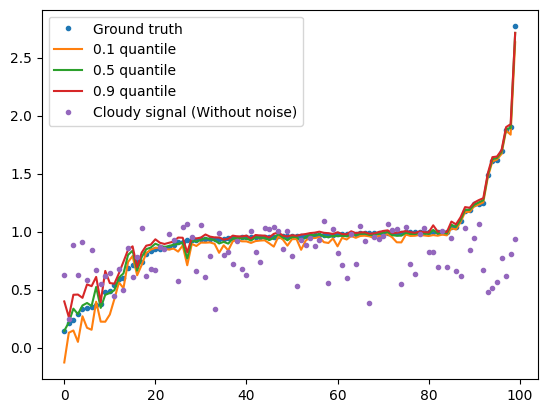

In [11]:
samples=100
channel=5

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','0.1 quantile', '0.5 quantile','0.9 quantile','Cloudy signal (Without noise)'])
plt.show()


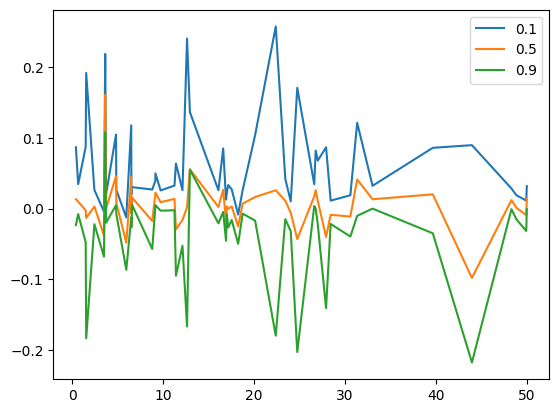

In [12]:
channel=5
samples=50

df_test=df.iloc[y_test.index]

#Get cot values
cot_column=df_test['COT'].to_numpy()
cot_column=cot_column[0:samples]
sort_ind=np.argsort(cot_column)
cot_column_sort=cot_column[sort_ind]

#Get ground truth
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

#Repeat ground truth to prepp difference
y_rep=np.repeat(y_plot_sort,len(quantiles),axis=0)
y_rep=np.reshape(y_rep,(-1,len(quantiles)))
diff=y_rep-y_pred_sort

#plt.plot(cot_column_sort,y_plot_sort,'.')
#plt.plot(cot_column_sort,y_pred_sort,'.')
plt.plot(cot_column_sort,diff)
plt.legend(['0.1','0.5','0.9'])

In [14]:
hf.save_model_and_test_data(filepath='pytorch_models/10epoch',model=model,X_test=X_test,y_test=y_test)

## Test multiple runs

In [6]:
num_epochs=[10,20]

sequential_models=[nn.Sequential(
    nn.Linear(len(X_labels),64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*len(y_labels))
),
nn.Sequential(
    nn.Linear(len(X_labels),128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128, len(quantiles)*len(y_labels))
)]

In [7]:
for nepochs in num_epochs:
    for i,sequantial in enumerate(sequential_models):
        model=QuantileNetwork(quantiles=quantiles)

        model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequantial)
        
        hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs_'+'network_index_'+str(i),
                                    model=model,X_test=X_test,y_test=y_test)
        
        

Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 447.21it/s]


Training loss [0.83508545] Validation loss [0.62981284]
----New best validation loss---- [0.62981284]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:03<00:00, 470.29it/s]


Training loss [0.5938237] Validation loss [0.5724689]
----New best validation loss---- [0.5724689]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 401.85it/s]


Training loss [0.55062705] Validation loss [0.53972024]
----New best validation loss---- [0.53972024]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 401.92it/s]

Training loss [0.52663654] Validation loss [0.52367455]
----New best validation loss---- [0.52367455]
Epoch 5



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 412.58it/s]

Training loss [0.51076293] Validation loss [0.51235425]
----New best validation loss---- [0.51235425]
Epoch 6



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 402.10it/s]


Training loss [0.49929383] Validation loss [0.50127894]
----New best validation loss---- [0.50127894]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 400.15it/s]


Training loss [0.48882237] Validation loss [0.49542388]
----New best validation loss---- [0.49542388]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 406.06it/s]

Training loss [0.4817636] Validation loss [0.47814092]
----New best validation loss---- [0.47814092]
Epoch 9



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 410.83it/s]


Training loss [0.47558063] Validation loss [0.4775147]
----New best validation loss---- [0.4775147]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 406.37it/s]


Training loss [0.4697666] Validation loss [0.4678289]
----New best validation loss---- [0.4678289]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 320.05it/s]


Training loss [0.736036] Validation loss [0.5824668]
----New best validation loss---- [0.5824668]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 312.87it/s]


Training loss [0.53765464] Validation loss [0.51077586]
----New best validation loss---- [0.51077586]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 316.40it/s]


Training loss [0.4975485] Validation loss [0.4831912]
----New best validation loss---- [0.4831912]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 315.95it/s]


Training loss [0.47509474] Validation loss [0.46123123]
----New best validation loss---- [0.46123123]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 308.60it/s]


Training loss [0.46134073] Validation loss [0.46613616]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 301.90it/s]


Training loss [0.4498692] Validation loss [0.4443084]
----New best validation loss---- [0.4443084]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 303.83it/s]


Training loss [0.4410767] Validation loss [0.4340277]
----New best validation loss---- [0.4340277]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 323.56it/s]


Training loss [0.43396753] Validation loss [0.44328737]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 317.80it/s]


Training loss [0.42952433] Validation loss [0.43190625]
----New best validation loss---- [0.43190625]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 316.68it/s]

Training loss [0.423864] Validation loss [0.423239]


----New best validation loss---- [0.423239]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 397.33it/s]


Training loss [0.46550938] Validation loss [0.4674661]
----New best validation loss---- [0.4674661]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 397.59it/s]


Training loss [0.46072677] Validation loss [0.46098593]
----New best validation loss---- [0.46098593]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 395.96it/s]


Training loss [0.45575485] Validation loss [0.45575827]
----New best validation loss---- [0.45575827]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 398.32it/s]


Training loss [0.45258376] Validation loss [0.45187417]
----New best validation loss---- [0.45187417]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 394.89it/s]

Training loss [0.44944212] Validation loss [0.44813833]
----New best validation loss---- [0.44813833]
Epoch 6



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 391.74it/s]

Training loss [0.44732052] Validation loss [0.4480687]
----New best validation loss---- [0.4480687]
Epoch 7



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 387.91it/s]

Training loss [0.44526616] Validation loss [0.44311658]
----New best validation loss---- [0.44311658]
Epoch 8



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 356.35it/s]


Training loss [0.44238296] Validation loss [0.4478645]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 392.29it/s]


Training loss [0.44048917] Validation loss [0.44160798]
----New best validation loss---- [0.44160798]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 400.67it/s]


Training loss [0.43798387] Validation loss [0.4358453]
----New best validation loss---- [0.4358453]
Epoch 11


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 409.52it/s]


Training loss [0.43721092] Validation loss [0.43711507]
Epoch 12


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 406.32it/s]


Training loss [0.4345179] Validation loss [0.4331449]
----New best validation loss---- [0.4331449]
Epoch 13


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 391.36it/s]

Training loss [0.4328985] Validation loss [0.4310257]
----New best validation loss---- [0.4310257]
Epoch 14



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 400.95it/s]


Training loss [0.43162265] Validation loss [0.43020603]
----New best validation loss---- [0.43020603]
Epoch 15


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 397.63it/s]

Training loss [0.4297698] Validation loss [0.43873972]
Epoch 16



Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 372.66it/s]


Training loss [0.4283286] Validation loss [0.42865148]
----New best validation loss---- [0.42865148]
Epoch 17


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 389.63it/s]


Training loss [0.42690247] Validation loss [0.43851897]
Epoch 18


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 396.70it/s]


Training loss [0.4265093] Validation loss [0.42374086]
----New best validation loss---- [0.42374086]
Epoch 19


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 366.01it/s]


Training loss [0.42438915] Validation loss [0.42492786]
Epoch 20


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 396.11it/s]


Training loss [0.42316002] Validation loss [0.42220765]
----New best validation loss---- [0.42220765]
Best model out of total max epochs found at epoch 20
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 318.26it/s]


Training loss [0.420448] Validation loss [0.41637716]
----New best validation loss---- [0.41637716]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 318.72it/s]

Training loss [0.41602948] Validation loss [0.4251766]
Epoch 3



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 317.36it/s]


Training loss [0.4127946] Validation loss [0.40777013]
----New best validation loss---- [0.40777013]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 317.32it/s]

Training loss [0.40959185] Validation loss [0.41486683]
Epoch 5



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 317.74it/s]

Training loss [0.40715286] Validation loss [0.403193]
----New best validation loss---- [0.403193]
Epoch 6



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 318.43it/s]


Training loss [0.40456155] Validation loss [0.4076635]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 307.98it/s]


Training loss [0.40146753] Validation loss [0.3994426]
----New best validation loss---- [0.3994426]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 307.35it/s]


Training loss [0.3999427] Validation loss [0.39930278]
----New best validation loss---- [0.39930278]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 309.06it/s]


Training loss [0.39832938] Validation loss [0.39774787]
----New best validation loss---- [0.39774787]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 299.74it/s]

Training loss [0.39611384] Validation loss [0.39565954]
----New best validation loss---- [0.39565954]
Epoch 11



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 317.90it/s]


Training loss [0.39431566] Validation loss [0.39378342]
----New best validation loss---- [0.39378342]
Epoch 12


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 314.15it/s]


Training loss [0.3923776] Validation loss [0.3941162]
Epoch 13


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 310.44it/s]


Training loss [0.3907729] Validation loss [0.40045735]
Epoch 14


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 309.70it/s]


Training loss [0.3884565] Validation loss [0.38296342]
----New best validation loss---- [0.38296342]
Epoch 15


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 282.57it/s]


Training loss [0.38813072] Validation loss [0.39029762]
Epoch 16


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 284.14it/s]


Training loss [0.3860818] Validation loss [0.3854317]
Epoch 17


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 306.48it/s]


Training loss [0.38454857] Validation loss [0.39033598]
Epoch 18


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 307.75it/s]

Training loss [0.38327152] Validation loss [0.39681497]
Epoch 19



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 315.59it/s]


Training loss [0.3824421] Validation loss [0.37885955]
----New best validation loss---- [0.37885955]
Epoch 20


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 317.48it/s]

Training loss [0.37975702] Validation loss [0.38331705]


Best model out of total max epochs found at epoch 19


## Testloading a model

In [2]:
model, X_test, y_test = hf.load_model_and_test_data(filepath='pytorch_models/10epochs_network_index_0')